In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from typing import Tuple, List
# from quantmatrix import quant_mat [error: np not defined]

In [2]:
# Quantization Matrix 
quant_mat = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]])

In [22]:
# open images
img1 = np.array(Image.open("Img1.tiff").convert("L"))
img2 = np.array(Image.open("Img2.tiff").convert("L"))
img3 = np.array(Image.open("Img3.tiff").convert("L"))
img4 = np.array(Image.open("Lena512.gif").convert("L"))

### Utility encoding modules

In [59]:
def GetImageBlocks(img:np.ndarray) -> List[np.ndarray]:
    h, w = img.shape
    h_new = h
    if h%8 != 0:
        h_new += 8-(h%8)
    w_new = w
    if h%8 != 0:
        w_new += 8-(w%8)
    
    # write image size to a file
    with open("config.txt","w") as f:
        f.write(f"{h_new} {w_new}")
    
    paddedImg = np.zeros((h_new, w_new))
    for i in range(h):
        for j in range(w):
            paddedImg[i,j] = img[i,j]
    
    imageBlocks = []
    
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = paddedImg[i:i+8, j:j+8]
            imageBlocks.append(block)
    
    return imageBlocks


In [58]:
def ApplyOffset(img:np.ndarray, offset:int=-128) -> np.ndarray:
    # assuming 8 bits
    offsetImg = img+offset
    return offsetImg

In [6]:
def ApplyDCT(img:np.ndarray) -> np.ndarray:
    return cv2.dct(np.asarray(img, dtype="float32"))

In [7]:
def ApplyQuantization(img:np.ndarray, quantMatrix:np.ndarray) -> np.ndarray:
    quantizedImg = img/quantMatrix
    roundImg = np.asarray(quantizedImg, dtype="int")
    return roundImg



In [8]:
def ApplyRLE(arr:np.ndarray) -> List:
    rle = []
    currZeros = 0
    for i in range(len(arr)):
        if arr[i] == 0:
            currZeros += 1
        else:
            rle.append((currZeros, arr[i]))
            currZeros = 0
    rle.append((0,0))
    return rle

In [9]:
# returns zigzag pattern of image (except top left pixel)
def GetZigZagScan(img:np.ndarray) -> np.ndarray:
    h, w = img.shape
    zigzag = np.zeros(h*w-1, dtype="int")
    
    y, x = 0, 1
    direction = "down"
    
    index = 0
    
    while index < h*w-1:
            
        zigzag[index] = img[y,x]
        index += 1
        
        if direction == "down":
            if y+1 >= h:
                x+=1
                direction = "up"
            elif x-1 < 0:
                y+=1
                direction = "up"
            else:
                y+=1
                x-=1
        else:
            if x+1 >= w:
                y+=1
                direction = "down"
            elif y-1 < 0:
                x+=1
                direction = "down"
            else:
                y-=1
                x+=1
            
    return zigzag
        


In [10]:
def GetDifferentialScan(blocks:List[np.ndarray]) -> List:
    dcValues = []
    for block in blocks:
        dcValues.append(block[0,0])
    for i in range(len(dcValues)-1, 0, -1):
        dcValues[i] -= dcValues[i-1]
    return dcValues



### Encoding modules as mentioned in lab

In [11]:
# BLOCK module
def block(img:np.ndarray) -> List[np.ndarray]:
    imgBlocks = GetImageBlocks(img)
    return imgBlocks

In [12]:
# ZIGZAG module
def zigzag(imgBlock:np.ndarray) -> List:
    zigzagScan = GetZigZagScan(imgBlock)
    return zigzagScan

In [13]:
# jDCenc module
def jDCenc(imgBlockArr:List[np.ndarray]) -> None:
    diffScan = GetDifferentialScan(imgBlockArr)
    with open("jDCenc.txt","w") as f:
        for x in diffScan:
            f.write(f"{x} ")
    return None

# output is written to jDCenc.txt

In [14]:
# jACenc module
def jACenc(imgBlockArr:List[np.ndarray]) -> None:
    with open("jACenc.txt","w") as f:
        for imgBlock in imgBlockArr:
            zigzagScan = zigzag(imgBlock)
            zigzagRLE = ApplyRLE(zigzagScan)
            for x in zigzagRLE:
                f.write(f"{x[0]},{x[1]} ")
            f.write("\n")
    return None

# output is written to jACenc.txt

In [61]:
# MyJPEGEncoder module

def MyJPEGEncoder(img:np.ndarray):
    
    # get blocks
    imgBlockArr = block(img)
    
    # apply offset
    for i in range(len(imgBlockArr)):
        imgBlockArr[i] = ApplyOffset(imgBlockArr[i])
    
    # apply dct
    for i in range(len(imgBlockArr)):
        imgBlockArr[i] = ApplyDCT(imgBlockArr[i])
    
    # apply quantization
    for i in range(len(imgBlockArr)):
        imgBlockArr[i] = ApplyQuantization(imgBlockArr[i], quant_mat)
    
    # encode DC
    jDCenc(imgBlockArr)
    
    # encode AC
    jACenc(imgBlockArr)
    
    return

MyJPEGEncoder(img1)

### Utility decoding modules

In [25]:
def DecodeDifferential(arr:List) -> List:
    decodedArr = arr
    for i in range(1, len(arr)):
        decodedArr[i] += decodedArr[i-1]
    return decodedArr

In [27]:
def DecodeRLE(arr:List, size = 8*8) -> List:
    
    # assuming arr is a list of tuples
    decodedArr = []
    for x in arr:
        for _ in range(x[0]):
            decodedArr.append(0)
        decodedArr.append(x[1])
        if x[0] == 0 and x[1] == 0:
            break
    
    remaining = size-len(decodedArr)
    
    for _ in range(remaining):
        decodedArr.append(0)
    
    return decodedArr


In [51]:
def DecodeZigZag(arr:List, height:int=8, width:int=8) -> np.ndarray:
    
    h,w = height,width
    
    imgBlock = np.zeros((h,w))
    
    y, x = 0, 1
    direction = "down"
    
    index = 0
    
    while index < h*w-1:
            
        imgBlock[y,x] = arr[index]
        index += 1
        
        if direction == "down":
            if y+1 >= h:
                x+=1
                direction = "up"
            elif x-1 < 0:
                y+=1
                direction = "up"
            else:
                y+=1
                x-=1
        else:
            if x+1 >= w:
                y+=1
                direction = "down"
            elif y-1 < 0:
                x+=1
                direction = "down"
            else:
                y-=1
                x+=1
    
    return imgBlock

In [55]:
def ApplyRescaling(img:np.ndarray, quantMatrix:np.ndarray) -> np.ndarray:
    rescaledImg = img*quantMatrix
    return rescaledImg

In [57]:
def ApplyIDCT(img:np.ndarray) -> np.ndarray:
    return cv2.idct(np.asarray(img, dtype="float32"))

In [63]:
def ConcatenateImgBlocks(imgBlockArr:List[np.ndarray], height:int, width:int) -> np.ndarray:
    
    concatenatedImg = np.zeros((height, width))
    
    index = 0
    
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            concatenatedImg[i:i+8, j:j+8] = imgBlockArr[index]
            index += 1
    
    return concatenatedImg

### Decoding modules as mentioned in lab

In [35]:
# jDCdec module
def jDCdec(filepath:str) -> List:
    
    dcValues = []
    
    with open("jDCenc.txt","r") as f:
        text = f.readline()
        dcValues = list(map(int, text.split()))
        
    dcValuesDecoded = DecodeDifferential(dcValues)
    
    return dcValuesDecoded



In [48]:
# jACdec module
def jACdec(filepath:str) -> List:
    
    acValues = []
    
    with open("jACenc.txt","r") as f:
        for line in f.readlines():
            tempList = []
            values = line.split(" ")
            for val in values:
                if val!="\n":
                    tempList.append(tuple(map(int,val.split(","))))
            acValues.append(tempList)
    
    rleDecoded = []
    for i in acValues:
        rleDecoded.append(DecodeRLE(i))

    return rleDecoded

# jACdec("jACenc.txt")

In [54]:
# izigzag module
def izigzag(rleDecAC:List) -> List[np.ndarray]:
    
    imgBlockArr = []
    
    for ac in rleDecAC:
        imgBlockArr.append(DecodeZigZag(ac))
    
    return imgBlockArr



In [66]:
# MyJPEGDecoder module
def MyJPEGDecoder(acfilepath:str, dcfilepath:str, configpath) -> np.ndarray:
    
    # decoding dc
    decodedDC = jDCdec(dcfilepath)
    
    # decoding ac
    decodedAC = jACdec(acfilepath)
    
    # getting back in zigzag
    imgBlockArr = izigzag(decodedAC)
    
    # adding dc values
    for i in range(len(decodedDC)):
        imgBlockArr[i][0,0] = decodedDC[i]
    
    # rescaling
    for i in range(len(imgBlockArr)):
        imgBlockArr[i] = ApplyRescaling(imgBlockArr[i], quant_mat)
    
    # apply idct
    for i in range(len(imgBlockArr)):
        imgBlockArr[i] = ApplyIDCT(imgBlockArr[i])
    
    # apply offset
    for i in range(len(imgBlockArr)):
        imgBlockArr[i] = ApplyOffset(imgBlockArr[i], 128)
    
    # get image size from config.txt
    height, width = 0,0
    with open(configpath,"r") as f:
        s = f.readline()
        height,width = map(int, s.split())
        
    # concatenate blocks
    decodedImg = ConcatenateImgBlocks(imgBlockArr, height, width)
    
    return decodedImg
    

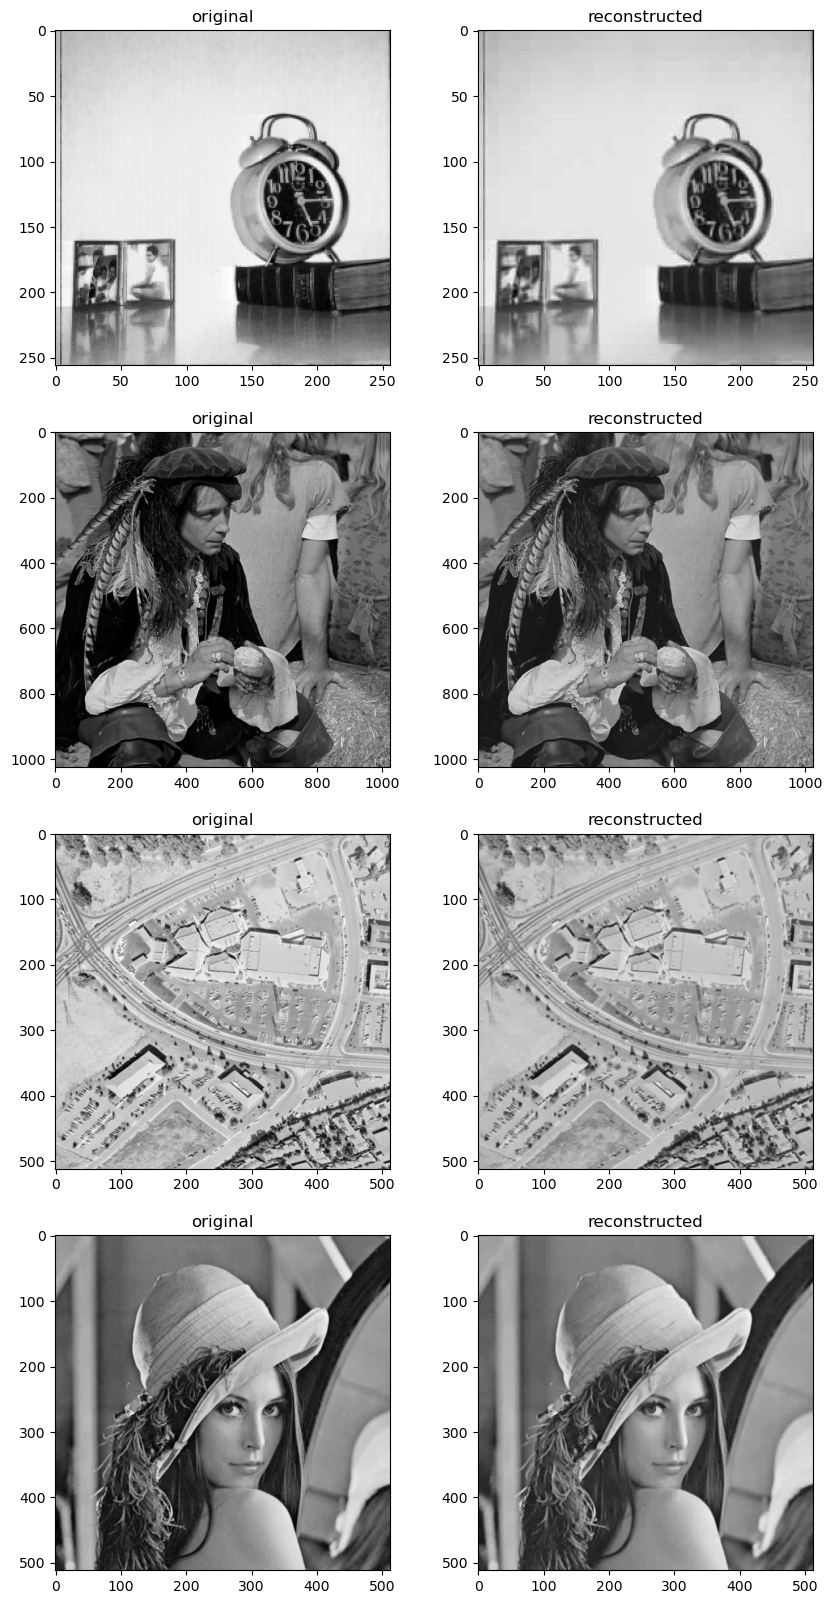

In [70]:
images = [img1, img2, img3, img4]

reconstructed = []

for img in images:
    MyJPEGEncoder(img)
    reconstructed.append(MyJPEGDecoder("jACenc.txt","jDCenc.txt","config.txt"))

plt.figure(figsize=(10,20))
for i in range(4):
    plt.subplot(4,2,1+2*i)
    plt.title("original")
    plt.imshow(images[i],cmap="gray")
    plt.subplot(4,2,2+2*i)
    plt.title("reconstructed")
    plt.imshow(reconstructed[i],cmap="gray")
